## 5.3.6 Negative binomial distribution and Meixner-chaos

$$ f(k; \beta, c) = \frac{(\beta)_k}{k!} (1-c)^{\beta} c^k = nbinom(k,\beta, 1-c)$$

[Negative Binomial Distribution in Python](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html)

$$ \zeta \sim nbinom(k,\beta, 1-c)$$

Meixner Polynomial:

$$
\begin{align*}
M_0(x; \beta, c) &= 1\\
M_1(x, \beta, c) &= 1+\frac{x}{\beta}(1-\frac{1}{c})\\
M_2(x, \beta, c) &= 1+\frac{2x}{\beta}(1-\frac{1}{c})+\frac{x^2-x}{\beta^2+\beta}(1-\frac{1}{c})^2\\
M_3(x, \beta, c) &= 1+\frac{3x}{\beta}(1-\frac{1}{c})+\frac{3(x^2-x)}{\beta^2+\beta}(1-\frac{1}{c})^2+\frac{(-1)(-x^3+3x^2-2x)}{\beta^3+3\beta^2+2\beta}(1-\frac{1}{c})^3\\
M_4(x, \beta, c) &= 1+\frac{4x}{\beta}(1-\frac{1}{c})+\frac{6(x^2-x)}{\beta^2+\beta}(1-\frac{1}{c})^2+\frac{(-4)(-x^3+3x^2-2x)}{\beta^3+3\beta^2+2\beta}(1-\frac{1}{c})^3+\frac{x^4-6x^3+11x^2-6x}{\beta^4+6\beta^3+11\beta^2+6\beta}(1-\frac{1}{c})^4\\
\cdots
\end{align*}
$$

Corresponding Hypergeometric orthogonal polynomial
$$ M_n(x; \beta, c) =\ _2F_1(-n,-x;\beta;1-\frac{1}{c})$$



In [7]:
import numpy as np
from scipy.stats import nbinom
from math import factorial
from matplotlib import pyplot as plt
from scipy.integrate import odeint

%matplotlib notebook

In [2]:
def Meix(params):
    '''
    The first 4 (degree from 0 to 4) Meixner polynomial
    Follow definition on P642
    '''
    n = params[0]  #degree
    b = params[1]  #parameter beta value
    c = params[2]  #parameter c value
    if n==0:
        return lambda u: 1
    elif n==1:
        return lambda u: 1+u*(1-1/c)/b
    elif n==2:
        return lambda u: 1+2*u*(1-1/c)/b+(u**2-u)*(1-1/c)**2/(b**2+b)
    elif n==3:
        return lambda u: 1+3*u*(1-1/c)/b+3*(u**2-u)*(1-1/c)**2/(b**2+b)+(-1)*(-u**3+3*u**2-2*u)*(1-1/c)**3/(b**3+3*b**2+2*b)
    else: #this actually means n=4
        return lambda u: 1+4*u*(1-1/c)/b+6*(u**2-u)*(1-1/c)**2/(b**2+b)+(-4)*(-u**3+3*u**2-2*u)*(1-1/c)**3/(b**3+3*b**2+2*b)+(u**4-6*u**3+11*u**2-6*u)*(1-1/c)**4/(b**4+6*b**3+11*b**2+6*b)

def factorial_rev(params):
    '''
    define Pochhammer  symbol (a)_n
    '''
    a=params[0]
    n=params[1]
    y=1
    if n == 0:
        return 1
    else:
        for i in range(n):
            y*=a+i
        return y
    
############# Meixner Chaos ###############
def inner2_me(params):
    '''
    n is the degree of Meixner polynomial
    beta is the parameter of negative binomial
    c is the parameter of negative binomial
    '''
    n = params[0]
    b = params[1]  #beta
    c = params[2]
    return (c)**(-n)*factorial(n)/factorial_rev((b,n))

def product3_me(i,j,l,params):
    #compute \Phi_i*\Phi_j*\Phi_l
    b = params[0]
    c = params[1]
    return lambda x: Meix((i,b,c))(x)*Meix((j,b,c))(x)*Meix((l,b,c))(x)

def inner3_me(i,j,l,params):
    #compute <\Phi_i\Phi_j\Phi_l>
    inner = 0 
    b = params[0]    #beta value
    c = params[1]
    for k in range(11):
        inner += factorial_rev((b, k))*((1-c)**b)*(c**k)*product3_me(i,j,l,params)(k)/factorial(k)
    
    return inner

In [3]:
def ode_system_me(y, t, P, params):   
    #P indicates the highest degree
    b = params[0]
    c = params[1]
    
    dydt = np.zeros(P+1) 
    for l in range(len(dydt)):
        dydt[l] = -(sum(sum(inner3_me(i,j,l,params)*ki_me[i]*y[j] for j in range(P+1)) for i in range(P+1)))/inner2_me((l,b,c))
    return dydt

In [4]:
P = 4
params = [1, 0.5]
ki_me = [1,-1]+[0]*(P-1)
sol_me = odeint(ode_system_me, [1.0]+[0.0]*P, np.linspace(0,1,101), args=(P, params)) 

In [5]:
def y_determ_me(x):
    return np.e**(-x)

### <font color = red>There is no $y_3$ plot in the paper

<IPython.core.display.Javascript object>


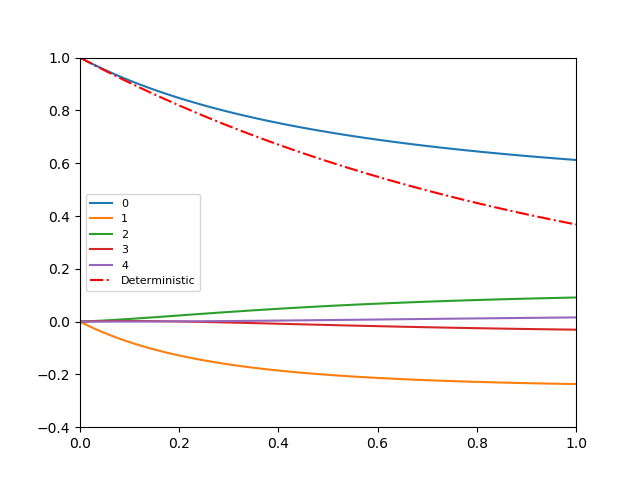

In [8]:
plt.figure()
plt.ylim([-0.4,1])
plt.xlim([0,1])

x= np.linspace(0,1,101)

for i in range(P+1):
    plt.plot(x,(-1)**i*sol_me[:,i],label=i)

plt.plot(x, y_determ_me(x), color='r', linestyle='-.',label='Deterministic')
plt.legend(prop={'size': 8})

### Error plot
$$
\bar{y}_{exact}(t) = \hat{y_0} \left(\frac{1-c}{1-ce^{-t}}\right)^{\beta} \ \ \ \ \ \ \ \ \bar{y}(t) = y_0
$$
So 
$$
\epsilon_{mean}(t) = \left| \frac{\bar{y}(t) - \bar{y}_{exact}(t)}{\bar{y}_{exact}(t)}\right|
$$

$$
\sigma_{exact}(t) = \hat{y_0}^2 \left(\frac{1-c}{1-ce^{-2t}}\right)^{\beta} - \hat{y_0}^2 \left(\frac{1-c}{1-ce^{-t}}\right)^{2\beta} \ \ \ \ \ \ \ \ \sigma(t) = a_1y_1^2 +a_2y_2^2+a_3y_3^2+a_4y_4^2
$$
The coefficients $(a_1, a_2, a_3, a_4)$ in $\sigma(t)$ can be obtained by code below.

So
$$
\epsilon_{variance}(t) = \left| \frac{\sigma(t) - \sigma_{exact}(t)}{\sigma_{exact}(t)} \right|= \ldots
$$

`nbinom.expect(func, args=(n, p), loc=0, lb=None, ub=None, conditional=False)`

<font color = red>This is $\beta=1, c=0.5$
$\downarrow$

In [28]:
allcoeff_536_0 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_536_0[0,:]=np.ones(4)
allcoeff_536_0[1,:]=-1*np.ones(4)
y_536_0 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [1, 0.5]
for i in range(4):
    P=i+1
    ki_me = allcoeff_536_0[:,i]
    y_mid=odeint(ode_system_me, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_536_0[:,i] = y_mid.tolist()+[0]*(4-P)

In [29]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(nbinom.expect(Meix((i,1,0.5)), args=(1, 0.5), loc=0, lb=None, ub=None, conditional=False))

1.0
-5.551117273674206e-17
-2.775525803461732e-17
5.5508400063680285e-17
5.552636113401536e-17
5.552636113401536e-17
5.552636113401536e-17
5.552636113401536e-17
5.552636113401536e-17


In [30]:
def g(params):
    n = params
    return lambda u: (Meix((n,1,0.5))(u))**2

for i in range(1,5):
    print(nbinom.expect(g(i), args=(1, 0.5), loc=0, lb=None, ub=None, conditional=False))

2.0000000000000004
4.000000000000001
8.000000000000002
16.000000000000007


In [31]:
b = 1
c = 0.5

mean_536_0 = y_536_0[0,:]
mean_exact_536_0 = ((1-c)/(1-c*np.e**(-1)))**b
error_mean_536_0=np.abs((mean_536_0 - mean_exact_536_0)/mean_exact_536_0)


sigma2_536_0=np.zeros(4)
for i in range(4):
    sigma2_536_0[i]=2*y_536_0[1,i]**2+4*y_536_0[2,i]**2+8*y_536_0[3,i]**2+16*y_536_0[4,i]**2    
sigma2_exact_536_0 = ((1-c)/(1-c*np.e**(-2)))**b - ((1-c)/(1-c*np.e**(-1)))**(2*b)
error_var_536_0=np.abs((sigma2_536_0-sigma2_exact_536_0)/sigma2_exact_536_0)

<font color = red>This is $\beta=2, c=0.5$
$\downarrow$

In [9]:
allcoeff_536_1 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_536_1[0,:]=2*np.ones(4)
allcoeff_536_1[1,:]=-2*np.ones(4)
y_536_1 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [2, 0.5]
for i in range(4):
    P=i+1
    ki_me = allcoeff_536_1[:,i]
    y_mid=odeint(ode_system_me, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_536_1[:,i] = y_mid.tolist()+[0]*(4-P)

In [10]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(nbinom.expect(Meix((i,2,0.5)), args=(2, 0.5), loc=0, lb=None, ub=None, conditional=False))

1.0
-5.551115123125783e-17
-5.551115123125783e-17
-5.551115123125783e-17
1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16
1.1102230246251565e-16


In [11]:
def g(params):
    n = params
    return lambda u: (Meix((n,2,0.5))(u))**2

for i in range(1,5):
    print(nbinom.expect(g(i), args=(2, 0.5), loc=0, lb=None, ub=None, conditional=False))

1.0
1.3333333333333337
2.0
3.1999999999999997


In [22]:
b = 2
c = 0.5

mean_536_1 = y_536_1[0,:]
mean_exact_536_1 = ((1-c)/(1-c*np.e**(-1)))**b
error_mean_536_1=np.abs((mean_536_1 - mean_exact_536_1)/mean_exact_536_1)


sigma2_536_1=np.zeros(4)
for i in range(4):
    sigma2_536_1[i]=1*y_536_1[1,i]**2+4/3*y_536_1[2,i]**2+2*y_536_1[3,i]**2+3.2*y_536_1[4,i]**2    
sigma2_exact_536_1 = ((1-c)/(1-c*np.e**(-2)))**b - ((1-c)/(1-c*np.e**(-1)))**(2*b)
error_var_536_1=np.abs((sigma2_536_1-sigma2_exact_536_1)/sigma2_exact_536_1)


<font color = red>This is $\beta=1, c=0.2$
$\downarrow$

In [23]:
allcoeff_536_2 = np.zeros((5,4))   #store ki value/ column 0 stores ki when P=1; column 1 stores ki when P=2
allcoeff_536_2[0,:]=1/4*np.ones(4)
allcoeff_536_2[1,:]=-1/4*np.ones(4)
y_536_2 = np.zeros((5,4))   #row 0 stores y0 for each P from 1-4; row 1 stores y1 for P from 1-4;...

params = [1, 0.2]
for i in range(4):
    P=i+1
    ki_me = allcoeff_536_2[:,i]
    y_mid=odeint(ode_system_me, [1.0]+[0.0]*P, np.linspace(0,1,2), args=(P, params))[1,:]
    y_536_2[:,i] = y_mid.tolist()+[0]*(4-P)

In [14]:
for i in range(9):
    #to compute $\bar{y}(t)$
    print(nbinom.expect(Meix((i,1,0.2)), args=(1, 0.8), loc=0, lb=None, ub=None, conditional=False))

1.0
2.0469737016526324e-16
8.326672684688674e-17
-8.326672684688674e-17
-2.7755575615628914e-16
-2.7755575615628914e-16
-2.7755575615628914e-16
-2.7755575615628914e-16
-2.7755575615628914e-16


In [20]:
def g(params):
    n = params
    return lambda u: (Meix((n,1,0.2))(u))**2

for i in range(1,5):
    print(nbinom.expect(g(i), args=(1, 0.8), loc=0, lb=None, ub=None, conditional=False))

4.999999999999999
24.999999999999996
124.99999999999996
625.0


In [24]:
b = 1
c = 0.2

mean_536_2 = y_536_2[0,:]
mean_exact_536_2 = ((1-c)/(1-c*np.e**(-1)))**b
error_mean_536_2=np.abs((mean_536_2 - mean_exact_536_2)/mean_exact_536_2)


sigma2_536_2=np.zeros(4)
for i in range(4):
    sigma2_536_2[i]=5*y_536_2[1,i]**2+25*y_536_2[2,i]**2+125*y_536_2[3,i]**2+625*y_536_2[4,i]**2    

sigma2_exact_536_2 = ((1-c)/(1-c*np.e**(-2)))**b - ((1-c)/(1-c*np.e**(-1)))**(2*b)
error_var_536_2=np.abs((sigma2_536_2-sigma2_exact_536_2)/sigma2_exact_536_2)


### <font color = red> The intersection is different from the paper

<IPython.core.display.Javascript object>


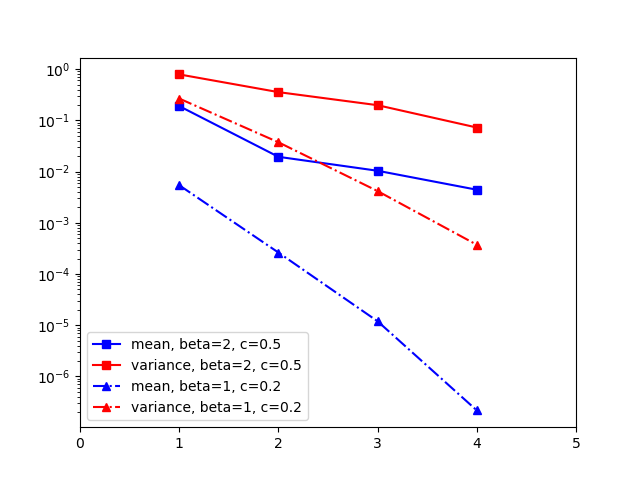

In [33]:
plt.figure()
plt.xlim([0,5])
#plt.semilogy([1,2,3,4],error_mean_536_0,'-gs',label='mean, beta=1, c=0.5')
#plt.semilogy([1,2,3,4],error_var_536_0,'-gs',label='variance, beta=1, c=0.5') 
plt.semilogy([1,2,3,4],error_mean_536_1,'-bs',label='mean, beta=2, c=0.5')
plt.semilogy([1,2,3,4],error_var_536_1,'-rs',label='variance, beta=2, c=0.5') 
plt.semilogy([1,2,3,4],error_mean_536_2,'-.b^',label='mean, beta=1, c=0.2')
plt.semilogy([1,2,3,4],error_var_536_2,'-.r^',label='variance, beta=1, c=0.2')
plt.legend()